In [54]:
!pip install colorcet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/260.3 kB ? eta -:--:--
   ---------------------------------- ----- 225.3/260.3 kB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 260.3/260.3 kB 4.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: C:\Users\shrey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Shape: (10000, 30)
Last 3 rows sample:
 [[1.17799518e-01 9.39220641e-02 8.33961646e-03 1.10599484e-02
  2.68129522e-02 1.72862576e-02 3.20918653e-03 1.12087926e-02
  1.14412406e-02 1.56386872e-02 2.30324974e-02 2.17874950e-02
  8.30236622e-03 7.31499336e-02 1.21936959e-01 8.03951529e-02
  2.88975184e-02 1.02892117e-01 8.42265686e-02 3.06753074e-02
  4.62654862e-03 1.35002267e-02 1.07619002e-02 6.80259784e-03
  3.29257300e-03 1.68643663e-03 3.83742531e-04 5.14091908e-05
  1.59784169e-04 5.44129705e-04]
 [1.17799518e-01 9.39220641e-02 8.33961646e-03 1.10599484e-02
  2.68129522e-02 1.72862576e-02 3.20918653e-03 1.12087926e-02
  1.14412406e-02 1.56386872e-02 2.30324974e-02 2.17874950e-02
  8.30236622e-03 7.31499336e-02 1.21936959e-01 8.03951529e-02
  2.88975184e-02 1.02892117e-01 8.42265686e-02 3.06753074e-02
  4.62654862e-03 1.35002267e-02 1.07619002e-02 6.80259784e-03
  3.29257300e-03 1.68643663e-03 3.83742531e-04 5.14091908e-05
  1.59784169e-04 5.44129705e-04]
 [1.17799518e-01 9.3922064

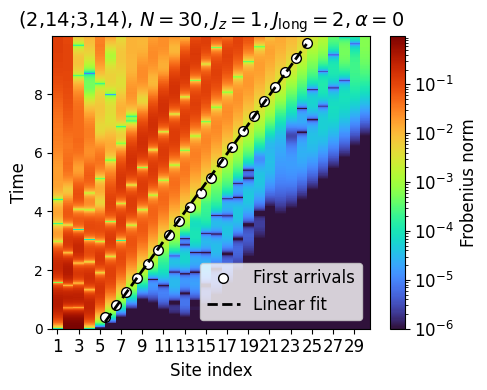

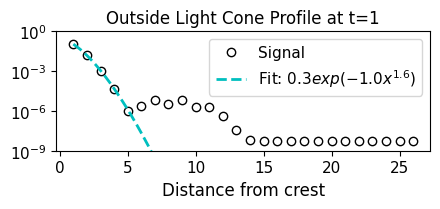

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N30B0LFIMHeffb2lcalpha05close.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [
    (5, 0.39), (6, 0.8), (7, 1.25), (8, 1.72),
    (9, 2.21), (10, 2.67), (11, 3.18), (12, 3.68), (13, 4.15),
    (14, 4.63), (15, 5.15), (16, 5.68), (17, 6.21), (18, 6.74),
    (19, 7.25), (20, 7.76), (21, 8.25), (22, 8.74), (23, 9.24),
    (24, 9.74)
]

x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,14;3,14), $N=30, J_z=1, J_{\mathrm{long}}=2, \alpha=0$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
# plt.savefig("plt/N15B0LFIMEmergentHfullb1lc.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-9, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
# plt.savefig("plt/N15B0LFIMEmergentHfullb1lcOutLC.svg", bbox_inches="tight") 
plt.show()



### Load mathematica data
Parser function

Shape: (10000, 15)
Last 3 rows sample:
 [[0.0017074  0.01025427 0.00858844 0.04876119 0.01178353 0.02010032
  0.05569278 0.09110392 0.02350792 0.01505585 0.06550871 0.00708423
  0.01390895 0.00577767 0.17899025]
 [0.0017074  0.01025427 0.00858844 0.04876119 0.01178353 0.02010032
  0.05569278 0.09110392 0.02350792 0.01505585 0.06550871 0.00708423
  0.01390895 0.00577767 0.17899025]
 [0.0017074  0.01025427 0.00858844 0.04876119 0.01178353 0.02010032
  0.05569278 0.09110392 0.02350792 0.01505585 0.06550871 0.00708423
  0.01390895 0.00577767 0.17899025]]
Fit slope = 0.455, intercept = -2.269


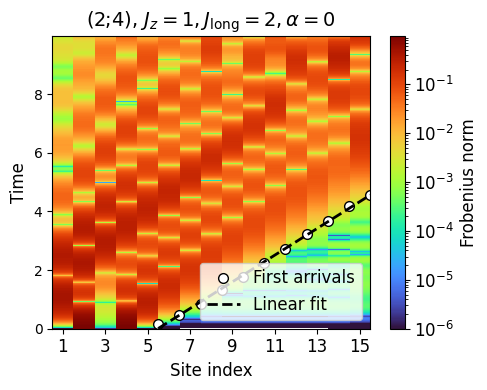

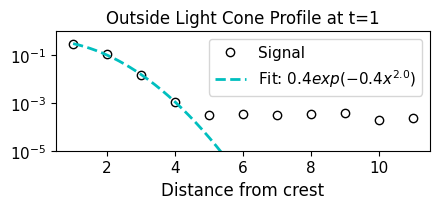

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "lcDataB0LFIMJx_large.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [
    (5, 0.16), (6, 0.46), (7, 0.84), (8, 1.31), (9, 1.77),
    (10, 2.23), (11, 2.72), (12, 3.22), (13, 3.66),
    (14, 4.18), (15, 4.55)
]

x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N15B0LFIMEmergentHfullb1lc.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMEmergentHfullb1lcOutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 15)
[3.05539934e-03 4.92673818e-02 3.07919399e-02 8.55669911e-02
 8.24661366e-02 6.08041676e-03 1.73578626e-02 5.37943043e-03
 2.12621258e-02 5.19207398e-05 4.91669412e-03 8.89933289e-03
 8.24355402e-03 1.35014584e-02 1.24984183e-02]


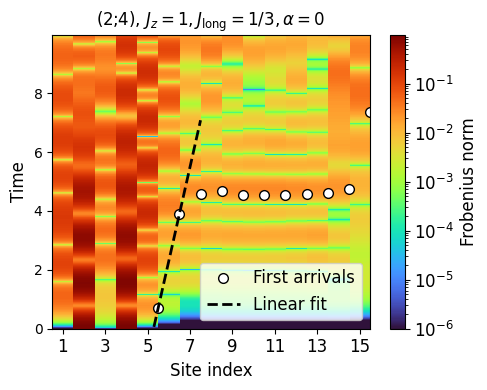

C:\Users\shrey\AppData\Local\Temp\ipykernel_9584\1535661139.py:154: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(log_model, x_fit_points, logy,


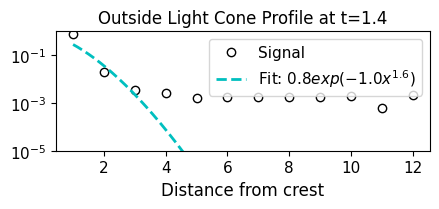

In [41]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "lcDataB0LFIMJx_small.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.7), (6, 3.89), (7, 4.58), (8, 4.67),
    (9, 4.54), (10, 4.54), (11, 4.53), (12, 4.56),
    (13, 4.61), (14, 4.73), (15, 7.37)
]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points[:2], y_points[:2], 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points[0]-0.2, x_points[2], 50)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max + 0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# # Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=1/3, \alpha=0$", fontsize=12)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels, fontsize=12)


plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMEmergentHfullb1lc2.svg", bbox_inches="tight") 
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1.4  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 3   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return -0.1 - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMEmergentHfullb1lc2lcOutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 13)
Last 3 rows sample:
 [[1.42418754e-04 1.07605274e-02 3.87784415e-03 7.22091129e-04
  1.33971098e-01 6.96350953e-02 5.95930417e-02 5.26042077e-02
  1.94403969e-02 7.19257439e-02 1.44701632e-02 2.46295876e-01
  1.55907815e-02]
 [3.64191211e-04 1.04515165e-02 3.74412077e-03 6.36754885e-04
  1.35477473e-01 7.25057580e-02 6.09345441e-02 5.43581139e-02
  2.10616430e-02 6.93848514e-02 2.05648374e-02 2.54482383e-01
  1.05924936e-02]
 [6.03853148e-04 1.01942691e-02 3.60801650e-03 5.43896453e-04
  1.36973856e-01 7.52987202e-02 6.21593726e-02 5.61700938e-02
  2.26137473e-02 6.67381690e-02 2.66888828e-02 2.62561207e-01
  5.64250590e-03]]
Fit slope = 0.460, intercept = -1.820


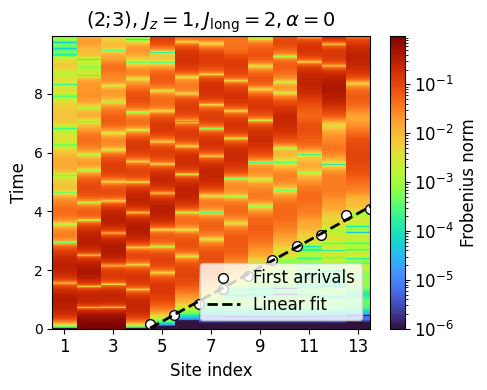

C:\Users\shrey\AppData\Local\Temp\ipykernel_21188\2678230793.py:153: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(log_model, x_fit_points, logy,


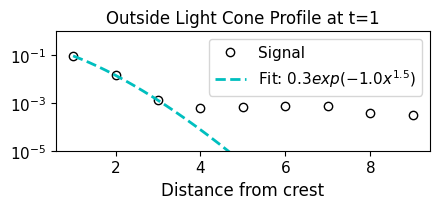

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "lcDataN13LFIMJlong2.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(4, 0.16), (5, 0.46), (6, 0.84), (7, 1.34), 
        (8, 1.79), (9, 2.35), (10, 2.81), (11, 3.21), 
        (12, 3.86), (13, 4.08)]

x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;3), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13LFIMJz1Jlong2.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 3   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N13LFIMJz1Jlong2OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[0.00031949 0.00713843 0.00489886 0.00801682 0.042549   0.0312969
  0.09144692 0.02172404 0.02154614 0.11854801 0.08589462 0.07663818
  0.08755051 0.00135499 0.19440958 0.09592186 0.08197375 0.05471996]
 [0.00027401 0.00681824 0.00547804 0.0069131  0.04368207 0.03192796
  0.0905126  0.01887299 0.02459893 0.11926091 0.08301774 0.07904802
  0.08608055 0.00404266 0.19446374 0.09578916 0.08420327 0.05483636]
 [0.00022671 0.0065002  0.0060611  0.00583933 0.04478208 0.03247018
  0.08950101 0.01597592 0.02758346 0.11986512 0.08006355 0.08137251
  0.08450281 0.00671101 0.19443514 0.0956958  0.08645432 0.05497293]]
Fit slope = 0.527, intercept = -2.030


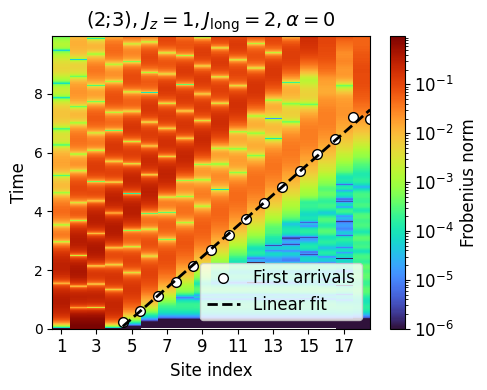

C:\Users\shrey\AppData\Local\Temp\ipykernel_21188\1664759713.py:155: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(log_model, x_fit_points, logy,


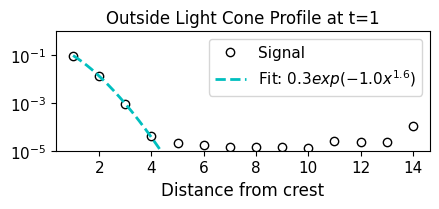

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "lcDataN18LFIMJlong2.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [
    (4, 0.22), (5, 0.6), (6, 1.1), (7, 1.6), (8, 2.13), (9, 2.67),
    (10, 3.2), (11, 3.75), (12, 4.29), (13, 4.83), (14, 5.38),
    (15, 5.94), (16, 6.48), (17, 7.21), (18, 7.16)
]

x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;3), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18LFIMJz1Jlong2.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 3   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18LFIMJz1Jlong2OutLC.svg", bbox_inches="tight") 
plt.show()



## alpha=0.5 band 2 init

#### band 2 far with N13, N18, without Kac

Shape: (1000, 13)
Last 3 rows sample:
 [[0.08487469 0.11770895 0.01391455 0.03537873 0.138302   0.04516777
  0.0080108  0.00406881 0.06386091 0.00218731 0.10379279 0.03340095
  0.01581142]
 [0.08570663 0.11262789 0.00726293 0.03883254 0.13833187 0.04427207
  0.0078046  0.0033125  0.06213201 0.00371179 0.10310243 0.03323363
  0.01594894]
 [0.0865507  0.10761182 0.0006448  0.04228207 0.13832405 0.04335339
  0.00760308 0.00254304 0.06032718 0.00521938 0.1023803  0.03307726
  0.01603498]]
Fit slope = 0.263, intercept = -0.691


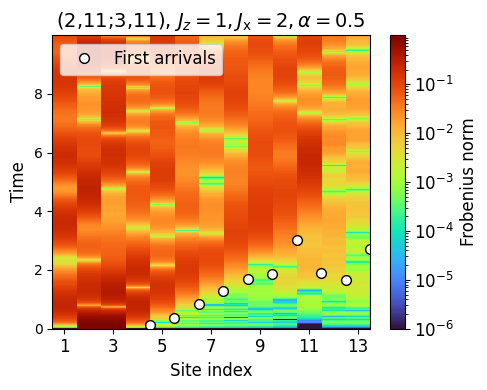

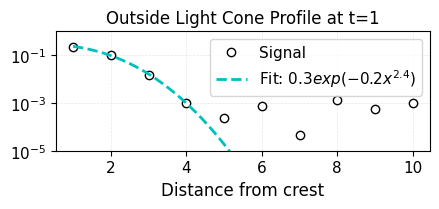

In [36]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N13Hfullb2farJz1Jx2a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(4, 0.11), (5, 0.35), (6, 0.84), (7, 1.27), (8, 1.70),
        (9, 1.87), (10, 3.02), (11, 1.91), (12, 1.67), (13, 2.71)]






x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,11;3,11), $J_z=1, J_{\mathrm{x}}=2, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13Hfullb2farJz1Jx2a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N13Hfullb2farJz1Jx2a05OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[1.45199133e-01 6.10023444e-03 9.79241733e-02 3.83121584e-02
  1.60895768e-02 1.91519579e-02 4.24967225e-02 2.42061312e-02
  1.40098536e-02 3.91151893e-02 8.34772339e-02 1.18333396e-02
  5.55516713e-02 4.08348715e-02 6.49887666e-03 1.90783204e-02
  5.38941978e-03 7.56033716e-05]
 [1.42984616e-01 6.14911249e-03 9.93107351e-02 3.84355590e-02
  1.72037688e-02 1.83003382e-02 4.18104414e-02 2.42614932e-02
  1.49014688e-02 3.93598151e-02 8.31188842e-02 1.20993736e-02
  5.57816418e-02 4.11174057e-02 6.43115789e-03 1.89594779e-02
  5.41071179e-03 1.06048537e-04]
 [1.40760648e-01 6.13108006e-03 1.00731689e-01 3.85752623e-02
  1.83436807e-02 1.73997448e-02 4.11336660e-02 2.43458771e-02
  1.58040306e-02 3.95426867e-02 8.26341910e-02 1.23440054e-02
  5.60064470e-02 4.13845992e-02 6.37631925e-03 1.88681546e-02
  5.46986268e-03 1.57230342e-04]]
Fit slope = 0.418, intercept = -1.733


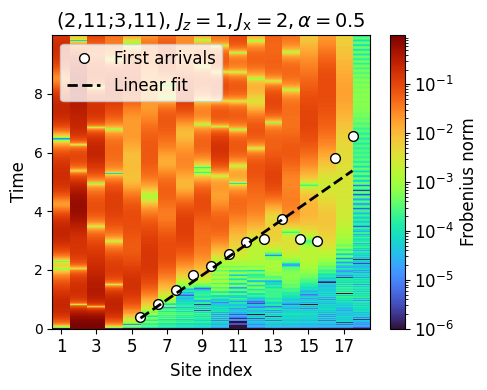

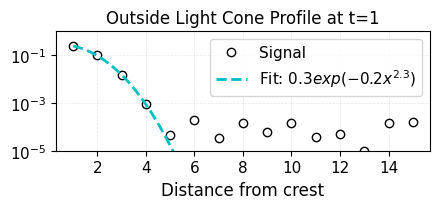

In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N18Hfullb2farJz1Jx2a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(5, 0.39), (6, 0.85), (7, 1.31), (8, 1.83), (9, 2.15),
        (10, 2.55), (11, 2.95), (12, 3.07), (13, 3.74), (14, 3.07),
        (15, 3.00), (16, 5.83), (17, 6.57)]





x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,11;3,11), $J_z=1, J_{\mathrm{x}}=2, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18Hfullb2farJz1Jx2a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18Hfullb2farJz1Jx2a05OutLC.svg", bbox_inches="tight") 
plt.show()



#### band 2 far with N13, N18, with Kac

Shape: (1000, 13)
Last 3 rows sample:
 [[0.08819195 0.2389706  0.04906626 0.07670097 0.06223838 0.04551904
  0.00735417 0.01797711 0.00805448 0.02676051 0.08732451 0.00920678
  0.0081287 ]
 [0.08859349 0.23920271 0.05100064 0.07435434 0.06237267 0.04611637
  0.00651631 0.01814089 0.00812323 0.02877748 0.09133955 0.00768018
  0.00813633]
 [0.08891839 0.2395175  0.05303815 0.0720598  0.06253312 0.04675991
  0.00568123 0.01834702 0.00818705 0.0307471  0.09532845 0.00612966
  0.00814632]]
Fit slope = 0.389, intercept = -1.596


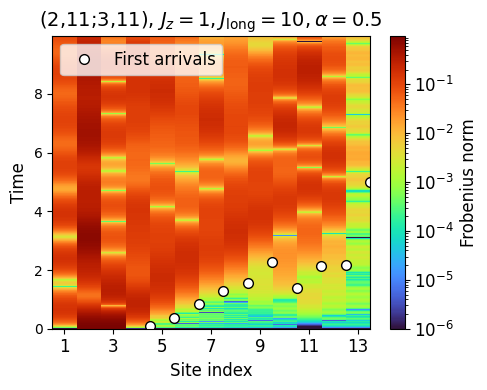

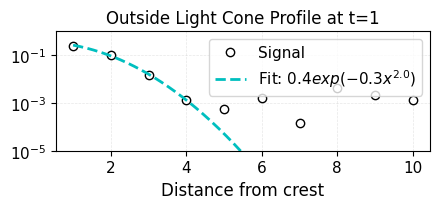

In [42]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N13Hfullb2farJz1Jlong10a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(4, 0.09), (5, 0.38), (6, 0.83), (7, 1.29), (8, 1.56),
        (9, 2.29), (10, 1.4), (11, 2.14), (12, 2.16), (13, 5.0)]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,11;3,11), $J_z=1, J_{\mathrm{long}}=10, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13Hfullb2farJz1Jlong10a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.savefig("plt/N13Hfullb2farJz1Jlong10a05OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[2.02961731e-01 4.05154173e-01 6.41156001e-02 1.89452207e-01
  1.01075867e-01 1.28712772e-02 7.87149737e-02 1.57385397e-02
  8.95875053e-02 5.44688469e-03 1.04686164e-01 1.19704456e-02
  3.71423849e-02 2.99469807e-02 6.00332861e-02 2.56093655e-02
  3.81803548e-03 1.27254177e-04]
 [2.03208445e-01 4.06993355e-01 6.53702852e-02 1.91160886e-01
  1.00296994e-01 1.26694345e-02 7.86867199e-02 1.55439811e-02
  9.01790037e-02 2.68245718e-03 1.10301294e-01 1.35084196e-02
  3.76298656e-02 2.98866507e-02 6.02040497e-02 2.58831788e-02
  3.90855803e-03 1.33985872e-04]
 [2.03380635e-01 4.08942402e-01 6.66301383e-02 1.92796799e-01
  9.94911507e-02 1.24779040e-02 7.86373085e-02 1.53694484e-02
  9.07264045e-02 9.01597742e-05 1.15886666e-01 1.50712328e-02
  3.81663340e-02 2.98196832e-02 6.03814847e-02 2.61686029e-02
  4.01324996e-03 1.54801260e-04]]
Fit slope = 0.369, intercept = -1.405


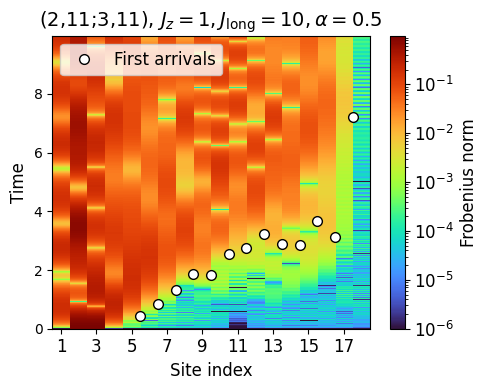

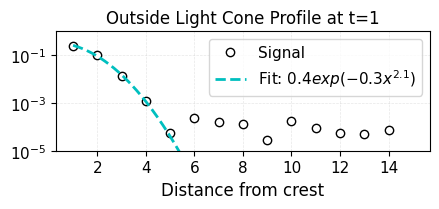

In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N18Hfullb2farJz1Jlong10a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(5, 0.42), (6, 0.85), (7, 1.32), (8, 1.87), (9, 1.84),
        (10, 2.54), (11, 2.74), (12, 3.23), (13, 2.89),
        (14, 2.84), (15, 3.68), (16, 3.13), (17, 7.2)]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,11;3,11), $J_z=1, J_{\mathrm{long}}=10, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18Hfullb2farJz1Jlong10a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18Hfullb2farJz1Jlong10a05OutLC.svg", bbox_inches="tight") 
plt.show()



#### band 2 close with N13, N18, without Kac

Shape: (1000, 13)
Last 3 rows sample:
 [[0.01326943 0.28463693 0.02877872 0.01667017 0.10751031 0.01887108
  0.049674   0.00614413 0.1215707  0.08524631 0.07831797 0.01127646
  0.00110982]
 [0.01209288 0.28302469 0.02690913 0.01570265 0.10721377 0.01936891
  0.04948822 0.0059333  0.12144232 0.08487853 0.07844612 0.01132169
  0.00091405]
 [0.01092245 0.28127282 0.02492646 0.01479389 0.10690198 0.01999486
  0.04923245 0.00577698 0.12132839 0.0844629  0.0785318  0.01137683
  0.00070082]]
Fit slope = 0.498, intercept = -2.453


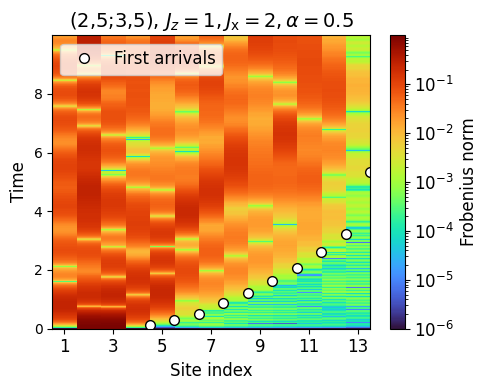

C:\Users\shrey\AppData\Local\Temp\ipykernel_36088\3517751210.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(log_model, x_fit_points, logy,


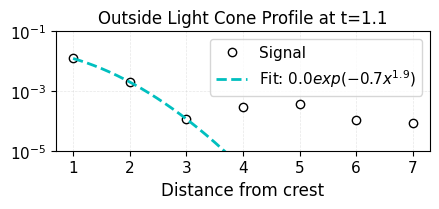

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N13Hfullb2closeJz1Jx2a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(4, 0.11), (5, 0.28), (6, 0.51), (7, 0.86), (8, 1.2),
        (9, 1.63), (10, 2.06), (11, 2.6), (12, 3.23), (13, 5.34)]





x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,5;3,5), $J_z=1, J_{\mathrm{x}}=2, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13Hfullb2closeJz1Jx2a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1.1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 6:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 3   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 0.1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N13Hfullb2closeJz1Jx2a05OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[6.78306983e-02 1.07067603e-02 1.18161089e-01 1.14283554e-02
  2.06753193e-01 1.31606266e-03 3.20621324e-02 1.50774576e-02
  1.34527002e-02 1.14787506e-02 2.34514622e-03 5.15910568e-03
  1.95056586e-03 3.47482327e-04 1.20106810e-02 9.65560863e-03
  1.70838565e-03 1.34506064e-04]
 [6.78604353e-02 1.36523073e-02 1.21955763e-01 1.33114957e-02
  2.05875637e-01 1.35674504e-03 3.16712702e-02 1.55590796e-02
  1.35791729e-02 1.13030186e-02 2.27000134e-03 5.15730600e-03
  1.88115965e-03 4.69598654e-04 1.19121476e-02 9.67221592e-03
  1.76288316e-03 1.47749613e-04]
 [6.79829886e-02 1.66218708e-02 1.25574859e-01 1.51526726e-02
  2.04940133e-01 1.41216020e-03 3.12272973e-02 1.60072564e-02
  1.37234256e-02 1.11568659e-02 2.20296417e-03 5.16032409e-03
  1.81809407e-03 5.87117103e-04 1.18169710e-02 9.71812340e-03
  1.87672796e-03 1.23440582e-04]]
Fit slope = 0.466, intercept = -2.653


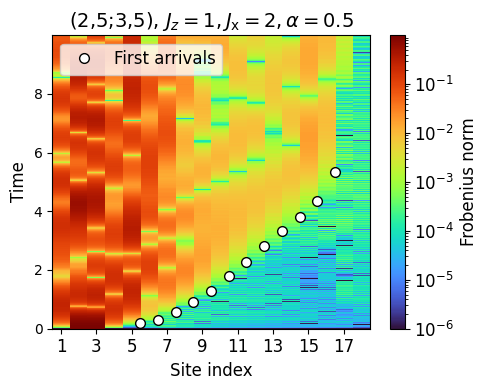

C:\Users\shrey\AppData\Local\Temp\ipykernel_36088\506485445.py:157: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(log_model, x_fit_points, logy,


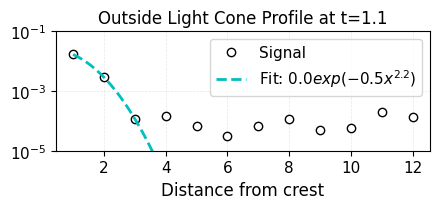

In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N18Hfullb2closeJz1Jx2a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [
    (5, 0.18), (6, 0.28), (7, 0.57), (8, 0.9),
    (9, 1.29), (10, 1.78), (11, 2.28), (12, 2.8),
    (13, 3.32), (14, 3.82), (15, 4.35), (16, 5.35)
]



x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,5;3,5), $J_z=1, J_{\mathrm{x}}=2, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18Hfullb2closeJz1Jx2a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1.1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 6:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 3   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 0.1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18Hfullb2closeJz1Jx2a05OutLC.svg", bbox_inches="tight") 
plt.show()



#### band 2 close with N13, N18, with Kac

Shape: (1000, 13)
Last 3 rows sample:
 [[8.55517383e-02 3.11933943e-01 1.94374890e-01 1.19754913e-01
  2.09326797e-01 4.49680233e-02 1.72060783e-02 1.64430374e-02
  1.07163222e-02 2.85776123e-02 7.22034937e-03 1.65542953e-03
  2.14828838e-04]
 [8.41717054e-02 3.13019540e-01 1.89083292e-01 1.15710335e-01
  2.12083122e-01 4.47150482e-02 1.53968768e-02 1.66882718e-02
  1.07321221e-02 2.87438656e-02 7.31144498e-03 1.73391304e-03
  3.36236646e-04]
 [8.26487196e-02 3.14131668e-01 1.83859399e-01 1.11586007e-01
  2.14856266e-01 4.43569429e-02 1.35700919e-02 1.69546091e-02
  1.07947484e-02 2.89327348e-02 7.36200882e-03 1.80391990e-03
  4.28015238e-04]]
Fit slope = 0.414, intercept = -2.000


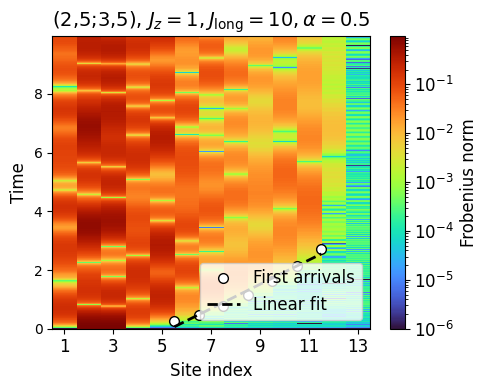

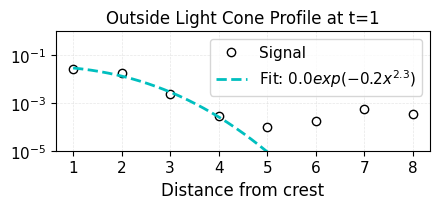

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N13Hfullb2closeJz1Jlong10a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [
    (5, 0.26), (6, 0.47), (7, 0.77),
    (8, 1.16), (9, 1.64), (10, 2.15), (11, 2.71)
]



x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,5;3,5), $J_z=1, J_{\mathrm{long}}=10, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13Hfullb2closeJz1Jlong10a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 5:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N13Hfullb2closeJz1Jlong10a05OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[6.91092035e-03 2.51826809e-01 6.00541366e-03 1.02441377e-01
  1.23721084e-01 3.18303815e-02 4.56579085e-02 1.55791071e-03
  1.88363862e-03 3.60073529e-03 9.73330191e-03 2.53197150e-03
  4.00278867e-03 1.42087306e-03 5.42916446e-03 2.82261454e-03
  4.66988498e-04 2.14218164e-04]
 [7.13845575e-03 2.57106491e-01 1.08645505e-02 9.88480933e-02
  1.28071439e-01 3.18340991e-02 4.53773680e-02 1.59783214e-03
  1.90154327e-03 3.49235011e-03 9.65174822e-03 2.53657352e-03
  4.02168465e-03 1.45104561e-03 5.45905276e-03 2.74340566e-03
  4.89382136e-04 3.29226398e-04]
 [7.19033244e-03 2.62302176e-01 1.57662970e-02 9.50926812e-02
  1.32381318e-01 3.17518691e-02 4.51191156e-02 1.57991504e-03
  1.86102025e-03 3.39870064e-03 9.56834302e-03 2.50713098e-03
  4.06163423e-03 1.49335231e-03 5.48681501e-03 2.69216941e-03
  4.86779300e-04 3.73641161e-04]]
Fit slope = 0.516, intercept = -2.741


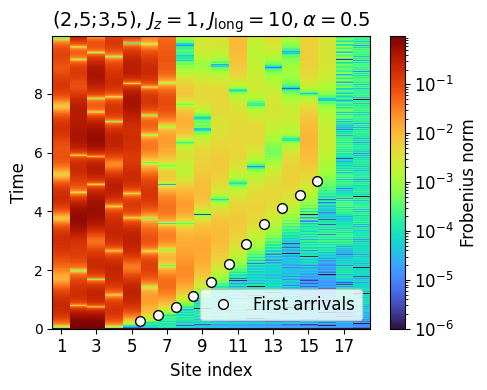

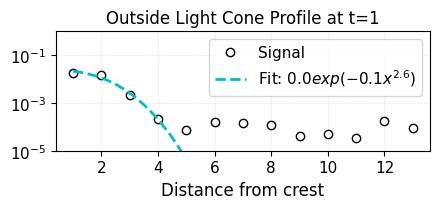

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N18Hfullb2closeJz1Jlong10a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(5, 0.25), (6, 0.46), (7, 0.75), (8, 1.11), (9, 1.6),
        (10, 2.21), (11, 2.89), (12, 3.58), (13, 4.13),
        (14, 4.55), (15, 5.05)]


x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2,5;3,5), $J_z=1, J_{\mathrm{long}}=10, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18Hfullb2closeJz1Jlong10a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 5:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18Hfullb2closeJz1Jlong10a05OutLC.svg", bbox_inches="tight") 
plt.show()



#### band 1 with N13, N18, without Kac

Shape: (1000, 13)
Last 3 rows sample:
 [[0.11900933 0.09857683 0.11223714 0.00224341 0.02698225 0.02482673
  0.04972784 0.05166782 0.02293639 0.00105831 0.01403521 0.00204581
  0.00042453]
 [0.11642834 0.10196185 0.11673064 0.00370955 0.02733088 0.02489611
  0.04948559 0.05145513 0.02285004 0.00101646 0.01402409 0.00212387
  0.00031502]
 [0.11375918 0.10545131 0.1215684  0.00518813 0.02775137 0.02492056
  0.04924025 0.05124973 0.02275445 0.00096879 0.01402941 0.00225767
  0.00015899]]
Fit slope = 0.487, intercept = -1.996


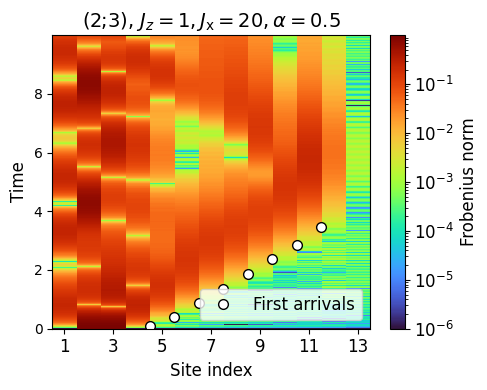

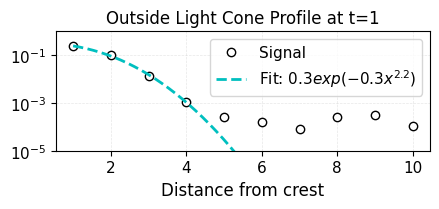

In [67]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N13Hfullb1Jz1Jx2a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(4, 0.09), (5, 0.41), (6, 0.86), (7, 1.35),
        (8, 1.85), (9, 2.36), (10, 2.86), (11, 3.47)]



x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;3), $J_z=1, J_{\mathrm{x}}=20, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13Hfullb1Jz1Jx20a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N13Hfullb1Jz1Jx20a05OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[1.81972188e-05 7.22495202e-01 5.01120070e-01 2.75657070e-02
  2.89591883e-02 3.77224826e-02 1.66430396e-02 1.45898771e-02
  1.67337985e-02 8.65740801e-03 2.37906531e-03 1.37184493e-02
  2.31476125e-02 2.55296925e-03 2.17702146e-02 6.79973684e-03
  5.40536011e-04 4.28272659e-04]
 [1.40754234e-03 7.34313187e-01 5.12105832e-01 2.86013888e-02
  2.81953211e-02 3.75902805e-02 1.64387335e-02 1.46182155e-02
  1.67875091e-02 8.63778573e-03 2.45740059e-03 1.38813890e-02
  2.30782497e-02 2.46253930e-03 2.16219108e-02 6.64444380e-03
  5.61347800e-04 5.41815257e-04]
 [2.74011566e-03 7.45698187e-01 5.22673263e-01 2.95229685e-02
  2.74677767e-02 3.75146065e-02 1.63414759e-02 1.46745635e-02
  1.68314535e-02 8.61542219e-03 2.54761108e-03 1.40558239e-02
  2.30407805e-02 2.39102380e-03 2.15108290e-02 6.60796597e-03
  5.61629830e-04 5.65680870e-04]]
Fit slope = 0.626, intercept = -2.912


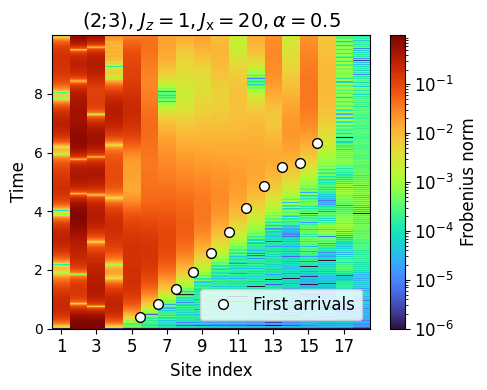

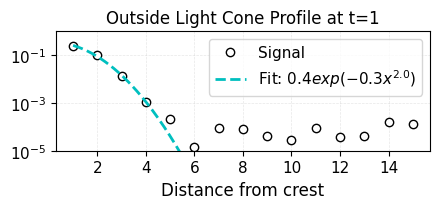

In [69]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N18Hfullb1Jz1Jx2a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(5, 0.39), (6, 0.83), (7, 1.34), (8, 1.92),
        (9, 2.57), (10, 3.3), (11, 4.1), (12, 4.86),
        (13, 5.51), (14, 5.64), (15, 6.32)]





x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;3), $J_z=1, J_{\mathrm{x}}=20, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18Hfullb1Jz1Jx20a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18Hfullb1Jz1Jx20a05OutLC.svg", bbox_inches="tight") 
plt.show()



#### band 1 with N13, N18, with Kac

Shape: (1000, 13)
Last 3 rows sample:
 [[5.02913881e-02 4.97324200e-01 9.56637721e-02 2.89330217e-01
  3.20817118e-02 2.22662870e-02 1.85024253e-02 2.21711962e-02
  3.75666923e-02 9.43322888e-03 1.85441284e-02 1.26256623e-03
  4.30256829e-04]
 [4.73881532e-02 5.09589839e-01 9.91850799e-02 2.93149831e-01
  3.34010558e-02 2.26833327e-02 1.87716216e-02 2.18138077e-02
  3.73892334e-02 9.45103083e-03 1.86056393e-02 1.58626002e-03
  1.79458621e-04]
 [4.45895519e-02 5.21816505e-01 1.02733984e-01 2.96950789e-01
  3.48902704e-02 2.32546279e-02 1.91080600e-02 2.15305707e-02
  3.73389819e-02 9.55957811e-03 1.86424802e-02 1.92269061e-03
  1.26144306e-04]]
Fit slope = 0.487, intercept = -1.996


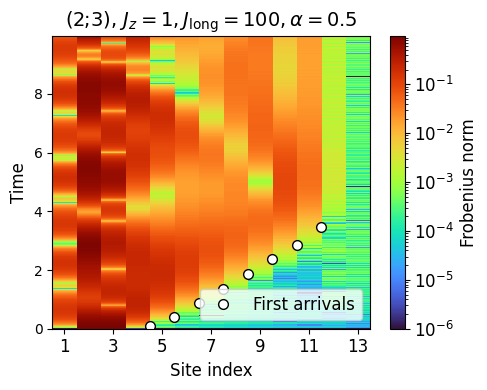

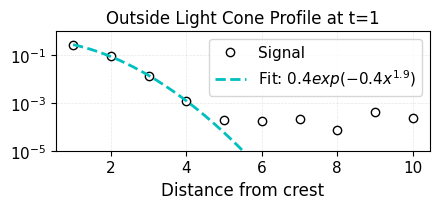

In [64]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N13Hfullb1Jz1Jlong10a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(4, 0.09), (5, 0.41), (6, 0.86), (7, 1.35),
        (8, 1.85), (9, 2.36), (10, 2.86), (11, 3.47)]



x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;3), $J_z=1, J_{\mathrm{long}}=100, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N13Hfullb1Jz1Jlong100a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N13Hfullb1Jz1Jlong100a05OutLC.svg", bbox_inches="tight") 
plt.show()



Shape: (1000, 18)
Last 3 rows sample:
 [[1.33347179e-02 5.50839997e-02 2.97477672e-01 4.39154274e-02
  1.53630363e-01 8.79319520e-02 3.34964726e-02 1.52462386e-02
  6.17225581e-03 3.69782779e-03 3.14765671e-03 2.47339558e-03
  5.32364629e-03 2.72423027e-03 5.23240233e-03 6.97965868e-04
  2.17323996e-04 2.08127924e-04]
 [1.13915966e-02 5.42392883e-02 3.00361182e-01 4.31258799e-02
  1.54081916e-01 8.78276806e-02 3.37193800e-02 1.53476072e-02
  6.03839819e-03 3.49130685e-03 3.06177851e-03 2.53110930e-03
  5.50726082e-03 2.85834105e-03 5.30479675e-03 9.77680686e-04
  6.18348132e-04 4.10526097e-04]
 [9.48913444e-03 5.34549904e-02 3.02892202e-01 4.26048815e-02
  1.54742687e-01 8.77946369e-02 3.39588795e-02 1.54841000e-02
  5.92999183e-03 3.32703268e-03 3.00580727e-03 2.65103076e-03
  5.68947184e-03 2.83205269e-03 5.30042634e-03 1.23125325e-03
  8.39897515e-04 4.97052051e-04]]
Fit slope = 0.574, intercept = -2.634


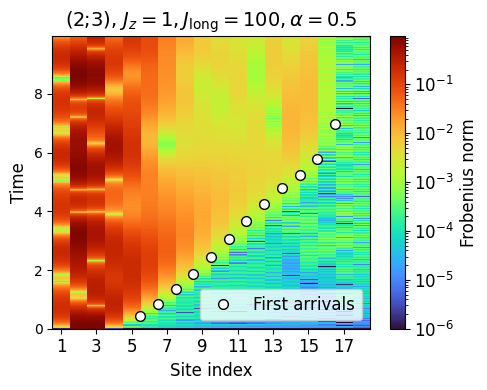

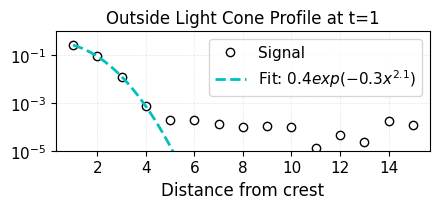

In [65]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    Example line: {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    
    Returns:
        np.ndarray: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces and whitespace
            line = line.strip().lstrip("{").rstrip("}")

            if not line:
                continue  # skip empty lines

            # Split by commas
            entries = line.split(",")

            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:  # drop imaginary parts like "+ 0.*I"
                    e = e.split("+")[0].strip()
                if "*I" in e:  # just in case some entries are pure imaginary
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N18Hfullb1Jz1Jlong10a05.txt")

# Load data from file
raw_data = load_mathematica_data(data_path)

print("Shape:", raw_data.shape)
print("Last 3 rows sample:\n", raw_data[-3:])  # safer than raw_data[-3]

# === First arrival points (site, time) ===
arrivals = [(5, 0.43), (6, 0.85), (7, 1.34), (8, 1.88),
        (9, 2.46), (10, 3.06), (11, 3.67), (12, 4.25),
        (13, 4.78), (14, 5.24), (15, 5.79), (16, 6.97)]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.LogNorm(vmin=1e-6, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max]
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
# plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

# Labels
cbar = plt.colorbar(im, label="Frobenius norm")
cbar.ax.tick_params(labelsize=12)   # set tick font size
cbar.set_label("Frobenius norm", fontsize=12)  # set label font size

plt.xlabel("Site index", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"(2;3), $J_z=1, J_{\mathrm{long}}=100, \alpha=0.5$", fontsize=14)

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)
plt.xticks(positions, labels, fontsize=12)

plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

os.makedirs("plt", exist_ok=True)  # ensure folder exists
plt.savefig("plt/N18Hfullb1Jz1Jlong100a05.svg", bbox_inches="tight")
plt.show()
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 3:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 4   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(4.5, 2.2))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Signal")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=12)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=12)
plt.ylim(1e-5, 1)   # y-axis range
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.3)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("plt/N18Hfullb1Jz1Jlong100a05OutLC.svg", bbox_inches="tight") 
plt.show()

